# GloVe with Tensorflow 

## Resources
* Pennington et al (2014) [GloVe: Global Vectors for Word Representation](https://nlp.stanford.edu/pubs/glove.pdf) 
* Stanford NLP Group's GloVe webpage [https://nlp.stanford.edu/projects/glove/](https://nlp.stanford.edu/projects/glove/)
* Jon Gauthier's post: [A GloVe implementation in Python](http://www.foldl.me/2014/glove-python/)
* Grady Simon's implementation in Tensorflow + Python: [Github repository](https://github.com/GradySimon/tensorflow-glove)

In [1]:
import tensorflow as tf
import numpy as np

import random
import operator
import os
import sys
import time
import urllib
import zipfile

from collections import Counter, defaultdict
from datetime import datetime
from tempfile import gettempdir

from tensorboard.plugins import projector

In [2]:
print('Tensorflow', tf.__version__)
print('Python', sys.version)

Tensorflow 1.9.0
Python 3.5.2 (default, Nov 23 2017, 16:37:01) 
[GCC 5.4.0 20160609]


## Download and read the data from file
Helper functions adapted from [Tensorflow's Github repository](https://github.com/tensorflow/tensorflow/blob/r1.9/tensorflow/examples/tutorials/word2vec/word2vec_basic.py)

In [3]:
def maybe_download(url, filename, expected_bytes):
    "Download the file if not present, and make sure it's the right size."    
    local_filename = os.path.join(gettempdir(), filename)
    if not os.path.exists(local_filename):
        local_filename, _ = urllib.request.urlretrieve(url + filename, local_filename)
        statinfo = os.stat(local_filename)
        if statinfo.st_size == expected_bytes:
            print('Found and verified', filename)
        else:
            print(statinfo.st_size)
            raise Exception('Failed to verify ' + local_filename + 
                            '. Can you get to it with a browser?')
    return local_filename


def read_data(filename):
    "Extract the file enclosed in a zip file as a list of words (strings)."
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data


def build_dataset(words, min_count):
    "Process raw inputs into a dataset"
    counter = Counter(words).most_common()
    dictionary = {'UNK': 0}
    for word, count in counter:
        if 0 < count < min_count:
            break
        dictionary[word] = len(dictionary)
    data = list()
    for word in words:
        index = dictionary.get(word, 0)
        data.append(index)
    count = Counter(data).most_common()
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary


### Text8
http://mattmahoney.net/dc/textdata.html

In [4]:
filename = maybe_download(
    url='http://mattmahoney.net/dc/', filename='text8.zip', expected_bytes=31344016)

Found and verified text8.zip


## Process the data and build the dictionaries

In [5]:
data = read_data(filename)

MIN_COUNT = 9      #  words that occur < MIN_COUNT times are replaced with UNK
"""
data               :  list of IDs(int) representing the original words in text
count              :  maps IDs(int) to normalized count/frequency in text
dictionary         :  maps words(strings) to their IDs(int)
reverse_dictionary :  maps IDs(int) to words(strings)
"""
data, count, dictionary, reverse_dictionary = build_dataset(data, MIN_COUNT)
print('Total number of words in text: {:,}.'.format(len(data)))
vocab_size = len(dictionary)
print('Reduced vocabulary size: {:,}'.format(vocab_size))
print('The 5 most common words:', 
      [(reverse_dictionary[i], c) for i, c in count[:5]])
print('First 10 words in text:', 
      data[:10], [reverse_dictionary[i] for i in data[:10]])

Total number of words in text: 17,005,207.
Reduced vocabulary size: 50,096
The 5 most common words: [('the', 1061396), ('of', 593677), ('UNK', 417527), ('and', 416629), ('one', 411764)]
First 10 words in text: [5243, 3083, 12, 6, 195, 2, 3137, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


## Set the hyperparameter values

Levy et al (2015) [Improving Distributional Similarity with Lessons Learned from Word Embeddings](http://www.aclweb.org/anthology/Q15-1016) (comparison of algorithms)

In [6]:
batch_size = 1024       # number of training samples to process in parallel
embedding_size = 200    # dimension of the embedding vectors
learning_rate = 0.001   # used with Adam (lr=0.05 was used with Adagrad in paper)
window_size = 15        # num of context words each side (same as GloVe's demo.sh)

x_max = 20              # max cooccurrence threshold to cap weight (x_max=100 in paper)
alpha = 0.75            # fractional power scale used to weight cooccurences 

## Constructing the co-occurrence matrix
Section 4.2 of Pennington et al (2014)

In [7]:
def build_coocurences(window_size):
    "Returns cooccurrences (dict of dicts)"
    cooccur_matrix = defaultdict(lambda: defaultdict(int))
    weights = [1/i for i in range(1, window_size + 1)] # weight func 1/d
    for i in range(len(data)):
        if data[i] == 0: continue # ignore UNK words
        left_buffer = data[max(i-window_size, 0):i][::-1]
        right_buffer = data[i+1:i+window_size+1] 
        for j, word_id in enumerate(left_buffer):
            if word_id == 0: continue 
            cooccur_matrix[data[i]][word_id] += weights[j]
        for j, word_id in enumerate(right_buffer):
            if word_id == 0: continue
            cooccur_matrix[data[i]][word_id] += weights[j]
    return cooccur_matrix

In [8]:
cooccur_matrix = build_coocurences(window_size)
del data

In [9]:
import operator
rand_word = random.randint(1, len(dictionary))
print('The word "{}" cooccurs most with:'.format(reverse_dictionary[rand_word]))
for w, weight in sorted(cooccur_matrix[rand_word].items(), key=operator.itemgetter(1), reverse=True)[:5]:
    print(reverse_dictionary[w], '\t:', weight)

The word "priori" cooccurs most with:
a 	: 81.0688866688867
the 	: 17.524331224331213
of 	: 12.535325785325782
knowledge 	: 12.084401709401707
and 	: 8.262287712287712


## Preparing the training data 

See section 3.2 of Pennington et al (2014) for discussion on model complexity

In [10]:
def build_traindata():
    center_words, context_words, cooccurences = [], [], []
    for center_idx, d in cooccur_matrix.items():
        for context_idx, w_cooccur in d.items():
            center_words.append(center_idx)     # w_i
            context_words.append(context_idx)   # w_j
            cooccurences.append(w_cooccur)      # X_ij
    return (np.array(center_words, dtype=np.int32),
            np.array(context_words, dtype=np.int32),
            np.array(cooccurences, dtype=np.float32))

In [11]:
center_words, context_words, cooccurences  = build_traindata()
del cooccur_matrix

In [12]:
for i in range(10, 18): # 8 random pairs and their weighted cooccurence values
    print(center_words[i], reverse_dictionary[center_words[i]], 
          '->', context_words[i], reverse_dictionary[context_words[i]],
          '\t', cooccurences[i])

1 the -> 11 is 	 82319.555
1 the -> 12 as 	 55468.234
1 the -> 13 eight 	 24934.383
1 the -> 14 for 	 55497.14
1 the -> 15 s 	 41498.92
1 the -> 16 five 	 24337.941
1 the -> 17 three 	 25164.281
1 the -> 18 was 	 48895.508


In [13]:
len(center_words), len(context_words), len(cooccurences) # training set size

(55338292, 55338292, 55338292)

## Select validation set for monitoring training progress 

In [14]:
valid_size = 16       # random set of words to evaluate training progress
valid_window = 100    # pick from most common 100 words to observe progress

In [15]:
valid_examples = np.random.choice(np.arange(1, valid_window), valid_size, replace=False)
print([(ex, reverse_dictionary[ex]) for ex in valid_examples])

[(29, 'or'), (57, 'who'), (68, 'see'), (51, 'more'), (23, 'seven'), (73, 'b'), (94, 'state'), (11, 'is'), (42, 'but'), (65, 'time'), (93, 'often'), (32, 'be'), (27, 'it'), (17, 'three'), (2, 'of'), (4, 'one')]


## Building the Tensorflow Graph 

In [16]:
graph = tf.Graph()
with graph.as_default(): 
    with tf.name_scope('inputs'):
        center_inputs = tf.placeholder(tf.int32, shape=[None])
        context_inputs = tf.placeholder(tf.int32, shape=[None])
        cooccur_inputs = tf.placeholder(tf.float32, shape=[None])
        valid_dataset = tf.constant(valid_examples, tf.int32)
    
    with tf.name_scope('embeddings'):
        center_embeddings = tf.get_variable('center', shape=(vocab_size, embedding_size), 
                                     initializer=tf.random_uniform_initializer(-0.5, 0.5))
        center_bias = tf.get_variable('center_b', shape=(vocab_size),   
                                      initializer=tf.random_uniform_initializer(-0.5, 0.5))
        embedded_i = tf.nn.embedding_lookup(center_embeddings, center_inputs)
        bias_i = tf.nn.embedding_lookup(center_bias, center_inputs)

        context_embeddings = tf.get_variable('context', shape=(vocab_size, embedding_size), 
                                     initializer=tf.random_uniform_initializer(-0.5, 0.5))
        context_bias = tf.get_variable('context_b', shape=(vocab_size),
                                       initializer=tf.random_uniform_initializer(-0.5, 0.5))
        embedded_j = tf.nn.embedding_lookup(context_embeddings, context_inputs)
        bias_j = tf.nn.embedding_lookup(context_bias, context_inputs)
    
    with tf.name_scope('loss'):
        "These operations implement Equation 16 of the GloVe paper with the bias terms"
        log_cooccurences = tf.log(cooccur_inputs)
        weights = (tf.minimum(1.0, tf.pow(cooccur_inputs/x_max, alpha))
                   * 0.5)  # the 1/2 term for cost function is in cs224n Lecture 3 slides 
        predictions = (tf.reduce_sum(tf.multiply(embedded_i, embedded_j), axis=1)
                       + bias_i
                       + bias_j)
        loss = tf.losses.mean_squared_error(labels=log_cooccurences,
                                            predictions=predictions,
                                            weights=weights)
                       
    tf.summary.scalar('loss', loss)                             
    
    with tf.name_scope('optimizer'):
        train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss) # using Adam instead
    
    # Find embeddings most similiar to the validation examples (cosine)  
    with tf.name_scope('similarity'):
        embeddings = center_embeddings + context_embeddings  # sum center and context embeddings
        norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keepdims=True))
        normalized_embeddings = embeddings / norm
        valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
        similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)
        
    merged = tf.summary.merge_all()
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    

In [17]:
def get_logdir():
    root_logdir = 'tf_logs'
    if not os.path.exists(root_logdir):
        os.makedirs(root_logdir)
    now = datetime.utcnow().strftime('%Y%m%d%H%M%S')
    return "{}/run_{}/".format(root_logdir, now)

## Create session and train model 

In [18]:
num_epochs = 3
log_dir = get_logdir()
start = time.perf_counter()

with tf.Session(graph=graph) as sess:
    writer = tf.summary.FileWriter(log_dir, graph)
    init.run()         
    print('Initialized.')
    for epoch in range(num_epochs):
        average_loss = 0    
        # Print every epoch: most similar words for validation set
        sim = similarity.eval()
        for i in range(valid_size):
            valid_word = reverse_dictionary[valid_examples[i]]
            top_k = 8
            nearest = (-sim[i, :]).argsort()[1:top_k + 1]
            log_str = 'Nearest words to "{}": '.format(valid_word)
            close_words = [reverse_dictionary[nearest[k]]
                           for k in range(top_k)]
            print(log_str, ', '.join(close_words))
            
        print('Shuffling training data...')
        shuffle = np.random.permutation(len(center_words))
        center_words = center_words[shuffle]
        context_words = context_words[shuffle]
        cooccurences = cooccurences[shuffle]
        
        print('Training: epoch', epoch + 1)
        for step in range(0, len(center_words)//batch_size + 1):
            feed_dict = {
                center_inputs: center_words[step*batch_size:(step+1)*batch_size],
                context_inputs: context_words[step*batch_size:(step+1)*batch_size],
                cooccur_inputs: cooccurences[step*batch_size:(step+1)*batch_size],}
            run_metadata = tf.RunMetadata()
            _, summary, loss_val = sess.run([train_op, merged, loss],
                                            feed_dict=feed_dict,
                                            run_metadata=run_metadata)
            average_loss += loss_val
            writer.add_summary(summary, step)
                                
            if step % 5000 == 0 and step > 0:
                average_loss /= 5000
                print('Average loss at step {}: {}'.format(step, average_loss))
                average_loss = 0
            
            # Add metadata to visualize the graph every 50,000 runs in final epoch
            if (epoch == num_epochs - 1) and (step % 50000 == 0):
                writer.add_run_metadata(run_metadata, 'step{}'.format(step))
                
    final_embeddings = normalized_embeddings.eval()
    
    # Save embedding labels (the words) for projecting in tensorboard
    with open(log_dir + '/metadata.tsv', 'w') as f:
        for i in range(vocab_size):
            f.write(reverse_dictionary[i] + '\n')
    
    # Save model checkpoints
    saver.save(sess, os.path.join(log_dir, 'model.ckpt'))
    
    # Create tensorboard configuration for the embeddings
    config = projector.ProjectorConfig()
    embedding_conf = config.embeddings.add()
    embedding_conf.tensor_name = embeddings.name
    embedding_conf.metadata_path = os.path.join(log_dir, 'metadata.tsv')
    projector.visualize_embeddings(writer, config)
    
writer.close()
elapsed = time.perf_counter() - start
print('Finished training in {:.3f} minutes'.format(elapsed/60))

Initialized.
Nearest words to "or":  fora, favored, kuan, strand, clinics, nephi, muscles, redux
Nearest words to "who":  circumcise, rubbish, circassians, mortals, haliotis, holism, facie, beaumont
Nearest words to "see":  spreadsheets, olives, scattering, vaikundar, sagittarius, projectile, finalized, warfare
Nearest words to "more":  overworld, toy, upland, lk, project, pastors, clarified, psychologists
Nearest words to "seven":  gerardo, croydon, shirt, endogenous, gloucestershire, ambivalence, bethany, baines
Nearest words to "b":  twelfth, pyrrhus, ellipsis, manichean, died, qui, wannsee, corrode
Nearest words to "state":  freising, expenditures, harvey, inflammatory, fe, gurps, barking, kreutzmann
Nearest words to "is":  federalist, rolling, diana, unreleased, luca, decreased, modular, analyzer
Nearest words to "but":  feasibility, nes, cling, fukuyama, flo, london, door, pyre
Nearest words to "time":  pharaonic, fiscal, requirements, chronicler, hangman, universite, buffer, uph

## Plot the embeddings after applying t-SNE 
Source: https://github.com/tensorflow/tensorflow/blob/r1.9/tensorflow/examples/tutorials/word2vec/word2vec_basic.py

In [19]:
%matplotlib inline
def plot_with_labels(low_dim_embs, labels, filename):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(
            label,
            xy=(x, y),
            xytext=(5, 2),
            textcoords='offset points',
            ha='right',
            va='bottom')
    plt.savefig(filename)
    plt.show()

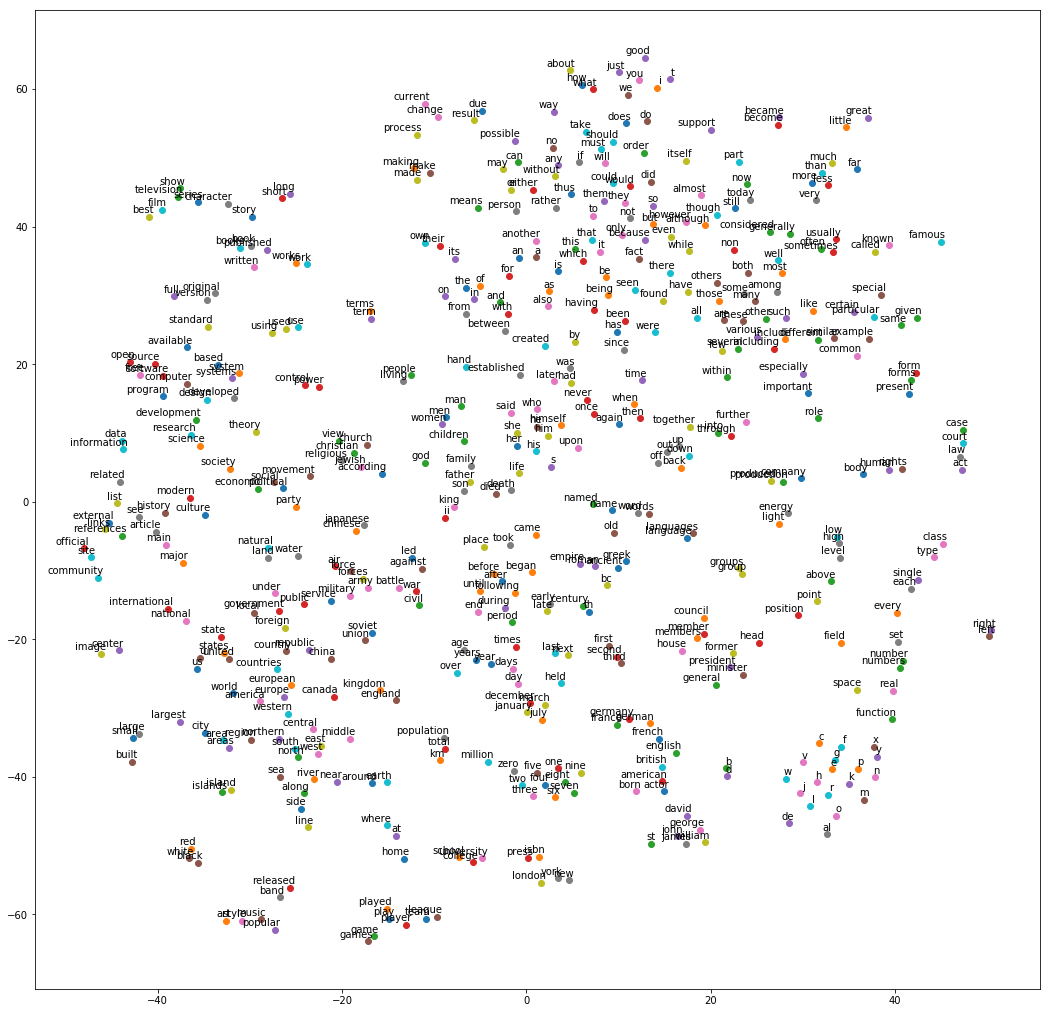

In [21]:
try:
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[1:plot_only+1, :]) # skip UNK at 0
    labels = [reverse_dictionary[i] for i in range(1, plot_only+1)]
    plot_with_labels(low_dim_embs, labels, os.path.join(gettempdir(), 'tsne.png'))

except ImportError as ex:
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')
    print(ex)